In [1]:
region_name = "ALL_10-800"  #"TDS" #"CAINGSGII_10-800"  #"TDS" #"WD" #"MDIS_10-800" # "TDS_ELAISN1"
region_dir_name = "./vasca_pipeline/"+region_name+"/"
region_fname = region_dir_name+"region_"+region_name+"_cat.fits"
rg_src_id = 357455

From https://arxiv.org/pdf/2106.07669.pdf

𝐴𝐺 = 0.835𝐴𝑉 (31)
𝐴𝐺BP = 1.139𝐴𝑉 (32)
𝐴𝐺RP = 0.650𝐴𝑉 (33)

In [2]:
AV = 0.01
AG= 0.835*AV
dBPmRp = (1.139+0.650)*AV
print(AG,dBPmRp)

0.00835 0.017890000000000003


In [3]:
# from __future__ import print_function
# from astropy.coordinates import SkyCoord

# from dustmaps.config import config
# config['data_dir'] = './resources/dustmaps'
# from dustmaps.edenhofer2023 import Edenhofer2023Query
# import astropy.units as units

# coords = SkyCoord(12.3*units.deg, -25.4*units.deg,
#                   distance=99.6056*units.pc, frame="icrs")
# edenhofer = Edenhofer2023Query(integrated=True)

# ebv = edenhofer(coords)

# print(ebv)

[[52925.31975 52925.61277]
 [55096.10218 55097.06439]
 [55104.57558 55106.78567]
 [55123.12991 55128.62543]]


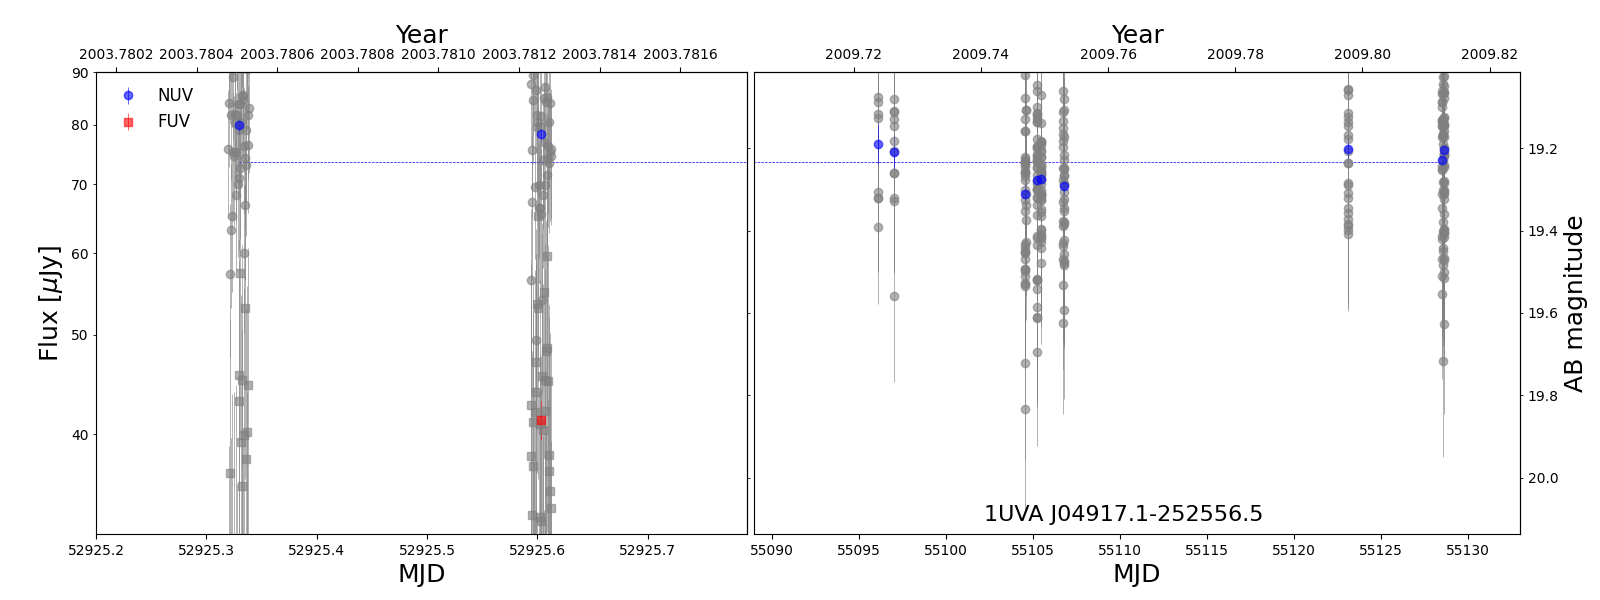

In [4]:
%matplotlib widget
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
from vasca.utils import get_lc_from_gphoton_npfile
from vasca.region import Region
import vasca.visualization as vvis
from vasca.utils import run_LombScargle, mag2flux, flux2mag
from astropy import units as uu
from matplotlib.ticker import ScalarFormatter, FuncFormatter
import numpy as np

#display(tt_gp_lc)

#Get source
rg = Region()
rg.load_from_fits(region_fname)
tc_src = rg.get_src_from_id(rg_src_id, load_from_file = False, add_sed=False,add_gphoton=False, add_spectrum=False)
tc_src.add_gphoton_lc(s2n_min=1.5, tbin = 40)
#tc_src.info()
#display(tc_src.tt_source_lc)
#display(tc_src.tt_visits)

t_start = tc_src.tt_visits["time_bin_start"]
t_stop = tc_src.tt_visits["time_bin_start"] + tc_src.tt_visits["time_bin_size"]/(24*60*60)
#[[55100,55110]] # [52925,52926],,[55095,55100],,[55120,55125],[55125,55130]
blocks_mjd = np.round([[t_start[0],t_stop[1]],
              [t_start[2],t_stop[3]],
              [t_start[4],t_stop[7]],
              [t_start[8],t_stop[10]]],5)
print(blocks_mjd)

#Plot LC
fig, axs = plt.subplots(1, 2, figsize=(16, 6),num="LC", clear=True, gridspec_kw={'width_ratios': [1.7, 2]})
axs = axs.flatten()
_ = vvis.plot_light_curve(tc_src, ax = axs[0])

def scientific(xx, pos):
    # xx:  tick value - ie. what you currently see in yticks
    # pos: a position - ie. the index of the tick (from 0 to 9 in this example)
    return str(np.round(xx,2))

scientific_formatter = FuncFormatter(scientific)
axs[0].xaxis.set_major_formatter(scientific_formatter)

axs[0].set_xlim([52925.2, 52925.79])
axs[0].set_ylim([3.2e1, 9e1])
#axs[0].grid(linestyle = '--') #
axs[0].texts[0].remove()
    
_ = vvis.plot_light_curve(tc_src, ax = axs[1])
axs[1].set_xlim([55089, 55133])
axs[1].set_ylim([3.2e1, 9e1])
axs[1].get_legend().remove()
y_axis = axs[1].axes.get_yaxis()
y_axis.set_visible(False)

plt.subplots_adjust(left=0.06, bottom=None, right=0.95, top=None, wspace=0.01, hspace=None)
plt.show()

#fig.savefig(region_dir_name +"LC_"+str(rg_src_id)+".pdf")


/home/buehler/miniforge3/envs/vas/lib/python3.10/site-packages/astropy/timeseries/periodograms/lombscargle/_statistics.py:140: RuntimeWarning: invalid value encountered in power
  return (1 - z) ** (0.5 * Nk)
/home/buehler/miniforge3/envs/vas/lib/python3.10/site-packages/astropy/units/quantity.py:666: RuntimeWarning: overflow encountered in expm1
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/buehler/miniforge3/envs/vas/lib/python3.10/site-packages/astropy/units/quantity.py:666: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


185.2527298624595 1 / d 0.16185070833328088 0.5867980101660274 0.8368302318779466 0.8493040297491706 164 6560.0
490.57611692292176 1 / d 0.3866903743866975 0.9588526020289703 0.4570535880073807 0.9712221241379382 20 800.0
396.0482796203579 1 / d 0.13976910034193457 0.009594967452780143 0.6921101745057705 0.9989743840903034 165 6600.0
220.28223895530013 1 / d 0.11444949137952223 0.854912819302203 0.9505148964830784 0.6234258517752206 106 4240.0


/home/buehler/Code/vasca/vasca/utils.py:357: RuntimeWarning: divide by zero encountered in divide
  return 1 / pp


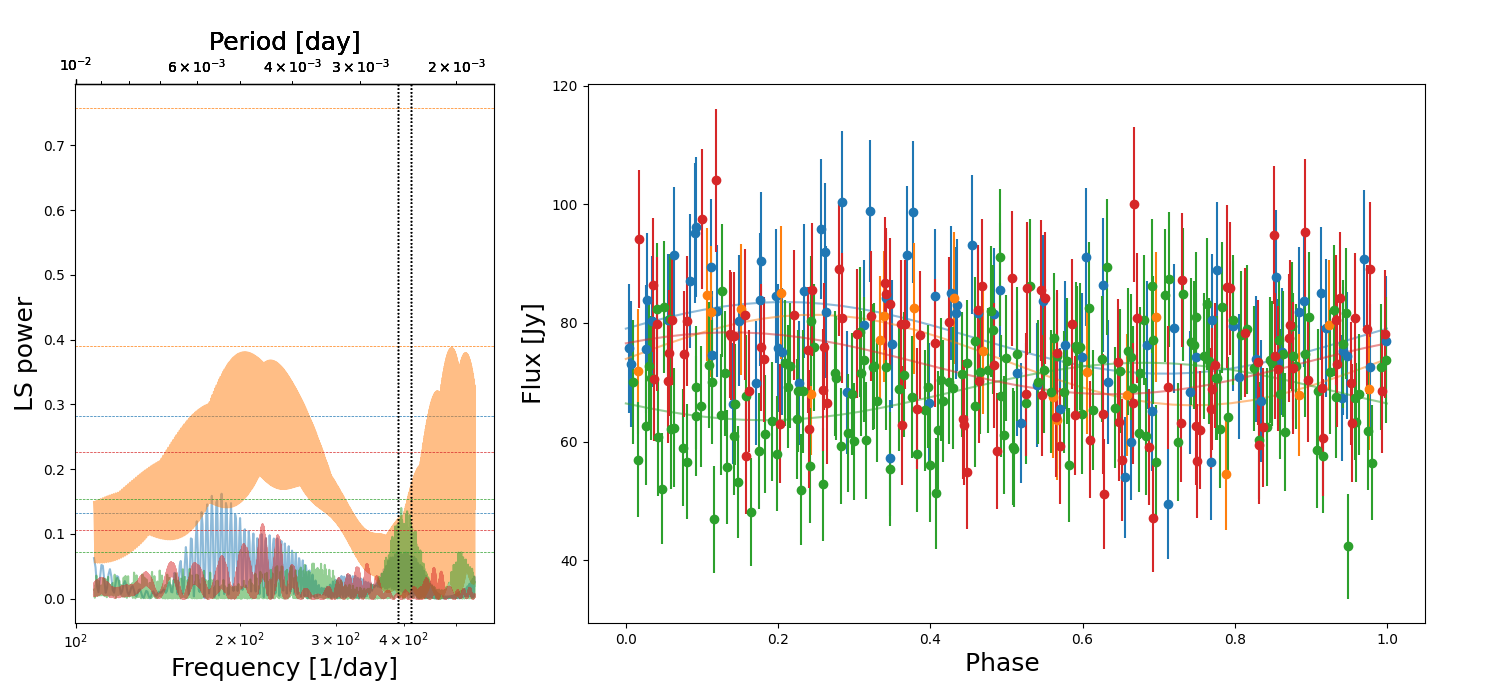

In [5]:
fig_ls, axs_ls = plt.subplots(1,2,figsize=(15, 7),squeeze=True, num="LS ", clear=True, gridspec_kw={'width_ratios': [1, 2]})
plt.subplots_adjust(left=0.05, bottom=None, right=0.95, top=None, wspace=0.15, hspace=None)
axs_ls = axs_ls.flatten()

#Add artificial variations
flux = tc_src.tt_gphoton_lc["flux"]
times = tc_src.tt_gphoton_lc["time"]
mean_flux = np.mean(flux)
periods = uu.d * [221.36 / (24*60*60),  209.3 / (24*60*60) ] # error 0.23
freqs = 1 / periods
#tc_src.tt_gphoton_lc["flux"] = flux + 0.15*mean_flux*np.sin(2*np.pi*times/periods[0].value) + 0.15*mean_flux*np.sin(2*np.pi*(times/periods[1].value+ 0.1))

sel = tc_src.tt_gphoton_lc["sel"]
for idx_block in range(0,len(blocks_mjd)):
    sel_block = (tc_src.tt_gphoton_lc["time"] > blocks_mjd[idx_block][0]) * (tc_src.tt_gphoton_lc["time"] < blocks_mjd[idx_block][1]) # Low flux window
#sel = (tc_src.tt_gphoton_lc["time"] > 55105) * (tc_src.tt_gphoton_lc["time"] < 55106)  # Low flux window
    sel_tot = sel*sel_block
    
    #print(flux,tc_src.tt_gphoton_lc["flux"])
    
    fig, ax, dd_ls_results_nuv = vvis.plot_lombscargle(tc_src.tt_gphoton_lc[sel_tot], ax=axs_ls[0], ax_phase = axs_ls[1], freq_range = [108,540]/ uu.d , plot_dtbins=False ) #, ax_lc = axs[0]
    #fig, ax, dd_ls_results_fuv =  vvis.plot_lombscargle(tc_src.tt_gphoton_lc, ax=axs_ls[2],obs_filter="FUV", ax_phase = axs_ls[3], freq_range = [24,1080]/ uu.d)
    axs_ls[0].axvline(x=freqs[0].value, color="black", linestyle=":", linewidth=1)
    axs_ls[0].axvline(x=freqs[1].value, color="black", linestyle=":", linewidth=1)
    print(dd_ls_results_nuv['ls_peak_freq'],dd_ls_results_nuv['ls_peak_power'],dd_ls_results_nuv['ls_peak_pval'], dd_ls_results_nuv['ls_model_rchiq'], dd_ls_results_nuv['ls_model_pval'], sel_block.sum(), tc_src.tt_gphoton_lc["time_bin_size"][sel_block].sum())
plt.show()
fig_ls.savefig(region_dir_name +"period_"+str(rg_src_id)+".pdf")

In [6]:
period = 220/(24*60*60)
freq = 1/period
print(period,freq)

0.0025462962962962965 392.7272727272727


In [7]:
display(tc_src.tt_gphoton_lc)

time,time_bin_size,flux,flux_err,sel,obs_filter,obs_filter_id,flags,s2n
d,s,1e-06 Jy,1e-06 Jy,,,,,
float64,float32,float32,float32,bool,bytes8,int32,int64,float32
52925.31997679398,40.0,75.7029,10.813585,True,NUV,1,0,8.173117
52925.32043975694,40.0,95.17192,11.798232,True,NUV,1,0,8.569342
52925.320902719905,40.0,83.947754,11.231889,True,NUV,1,0,8.372813
52925.321365682874,40.0,91.95061,11.628097,True,NUV,1,0,8.772316
52925.321828645836,40.0,57.27342,9.766958,True,NUV,1,0,6.953668
52925.3222916088,40.0,81.73316,11.104725,True,NUV,1,0,8.435803
...,...,...,...,...,...,...,...,...
52925.61159716435,40.0,35.207745,14.963103,True,FUV,2,0,3.367103


In [8]:
# from dustmaps.config import config
# config['data_dir'] = './resources/dustmaps'
# import dustmaps.edenhofer2023
# dustmaps.edenhofer2023.fetch()


In [9]:
mags = [19.2, 19.2-0.3]
flux = mag2flux(mags)
print(flux, (flux[1]-flux[0])/flux[0])

[ 75.8577575 100.       ] 1e-06 Jy 0.3182567385564074
